In [18]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision.transforms import v2
from torchvision import datasets

In [31]:
batch_size = 128

transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True)]#,
    #v2.Lambda(lambda x: x.view(-1) - 0.5)] # This we need when fitting a NN with nn.Linear(), but should not do this when using nn.Conv2d
    )

train_data = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
test_data = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

# Getting a subset of the data for speed purposes
num_samples = 100
indices = np.random.choice(len(train_data), num_samples, replace=False)
train_subset = Subset(train_data, indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

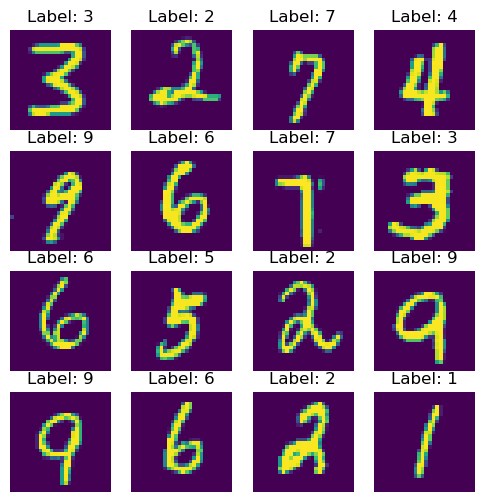

In [32]:
sizeData = train_data.data.shape[0]
idx = np.random.randint(sizeData, size=16)
dataSample = train_data.data[idx]
dataLabels = train_data.targets[idx]

fix, axes = plt.subplots(4, 4, figsize=(6,6))
for i, image in enumerate(dataSample):
    ax = axes[i//4, i%4]
    ax.imshow(image)
    ax.set_title("Label: {}".format(dataLabels[i]))
    ax.axis("off")

In [33]:
# class MNISTClassifier(nn.Module):

#     def __init__(self):
#         super(MNISTClassifier, self).__init__()

#         self.network = nn.Sequential(
#             nn.Linear(784, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 10),
#             nn.LogSoftmax(dim=1)
#         )

#     def forward(self, x):
#         return self.network(x)

# Not yet using data augmentation.
class MNISTClassifierConv(nn.Module):

    def __init__(self):
        super(MNISTClassifierConv, self).__init__()

        self.network = nn.Sequential(

            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), # Zoek uit wat deze argumenten inhouden
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # outputs 32 14 14

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # Zoek uit wat deze argumenten inhouden
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # outputs 64 7 7

            nn.Flatten(),

            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.network(x)

In [34]:
lr = 3e-4
epochs = 10

device = "cpu"
model = MNISTClassifierConv().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
lossfunction = nn.NLLLoss()

In [38]:
for epoch in range(epochs):
    running_loss = 0.0

    for images,labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        #images = images.view(images.shape[0], -1) # kan dit niet efficienter? gewoon -1 ofzo.
        optimizer.zero_grad() # waaarom zet je grad op zero? gaan ze anders accumuleren?
        outputs = model(images)
        loss = lossfunction(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader)}")
    

Epoch 1/10 - Loss: 1.8520716428756714
Epoch 2/10 - Loss: 1.8076298236846924
Epoch 3/10 - Loss: 1.7610268592834473
Epoch 4/10 - Loss: 1.7112597227096558
Epoch 5/10 - Loss: 1.6592433452606201
Epoch 6/10 - Loss: 1.6051772832870483
Epoch 7/10 - Loss: 1.5493580102920532
Epoch 8/10 - Loss: 1.4921445846557617
Epoch 9/10 - Loss: 1.433112621307373
Epoch 10/10 - Loss: 1.3727656602859497
Epoch 11/10 - Loss: 1.311212182044983
Epoch 12/10 - Loss: 1.2492691278457642
Epoch 13/10 - Loss: 1.188048243522644
Epoch 14/10 - Loss: 1.127036690711975
Epoch 15/10 - Loss: 1.0655730962753296
Epoch 16/10 - Loss: 1.0038684606552124
Epoch 17/10 - Loss: 0.9431934952735901
Epoch 18/10 - Loss: 0.8844165205955505
Epoch 19/10 - Loss: 0.8264837861061096
Epoch 20/10 - Loss: 0.7693694829940796
Epoch 21/10 - Loss: 0.714434027671814
Epoch 22/10 - Loss: 0.662401020526886
Epoch 23/10 - Loss: 0.6128666400909424
Epoch 24/10 - Loss: 0.567030131816864
Epoch 25/10 - Loss: 0.523668110370636
Epoch 26/10 - Loss: 0.48328763246536255
Ep

In [39]:
model.eval()
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test data: {accuracy:.2f}%")

Accuracy on test data: 77.62%
